# N06: DATA ANALYSIS: Final Analysis

## Notebook Description

This notebook provides a final analysis of the `flight` data and delays, focusing on the impact of routes and weather conditions on delays.

###
## Notebook Configuration

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Libraries import</p>

In [1]:
from psycopg2 import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, spearmanr
import statsmodels.api as sm
import os
from project_dir import DIR_PATH

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Connecting to the database</p>

In [2]:
cnx = connect(user='postgres_user', password='coderslab', host='localhost', database='airlines')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating the 'read_sql_table' method to extract data from the database</p>

In [3]:
def read_sql_table(table_name):
    query = f"SELECT * FROM {table_name}"
    cursor = cnx.cursor()
    cursor.execute(query)
    column_names = [desc[0] for desc in cursor.description]
    results = cursor.fetchall()
    cursor.close()
    cnx.close()
    df = pd.DataFrame(results, columns=column_names)   
    return df

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Loading the DataFrame 'flight_df_02', saved as a .csv file in the previous notebook</p>

In [4]:
flight_df = pd.read_csv(f"{DIR_PATH}{os.path.sep}data{os.path.sep}processed{os.path.sep}flight_df_02.csv")

In [5]:
flight_df

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg
0,0,1,1,2,9E,N931XJ,3290,10874,10397,600,...,NaN,NaN,NaN,NaN,NaN,False,False,"(500, 600]",2008,2007
1,1,1,1,2,OH,N723PS,5495,10874,11057,704,...,NaN,NaN,NaN,NaN,NaN,True,False,"(300, 400]",2004,2004
2,2,1,1,2,OH,N525EA,5416,10874,11057,1944,...,NaN,NaN,NaN,NaN,NaN,False,False,"(300, 400]",2004,2004
3,3,1,1,2,OH,N706PS,5426,10874,11057,1521,...,NaN,NaN,NaN,NaN,NaN,False,False,"(300, 400]",2004,2004
4,4,1,1,2,OH,N262PS,5440,10874,14100,756,...,NaN,NaN,NaN,NaN,NaN,False,False,"(300, 400]",2004,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922919,9251553,12,30,1,MQ,N818AE,3744,12511,13930,1411,...,2.0,0.0,0.0,0.0,31.0,True,False,"(400, 500]",2002,2001
6922920,9251554,12,30,1,MQ,N821AE,4235,12511,11298,1615,...,NaN,NaN,NaN,NaN,NaN,False,False,"(300, 400]",2002,2001
6922921,9251556,12,31,2,MQ,N245NN,4040,12511,11298,745,...,224.0,129.0,0.0,0.0,0.0,True,False,"(300, 400]",2016,2016
6922922,9251557,12,31,2,MQ,N806AE,3744,12511,13930,1411,...,3.0,0.0,0.0,0.0,71.0,True,False,"(400, 500]",2001,2001


###
## Enriching The Dataset With Additional Information From The `airport_list` Table

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Loading the 'airport_list' table form the database</p>

In [6]:
airport_list_df = read_sql_table('airport_list')
airport_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    97 non-null     int64 
 1   origin_airport_id     97 non-null     int64 
 2   display_airport_name  97 non-null     object
 3   origin_city_name      97 non-null     object
 4   name                  97 non-null     object
dtypes: int64(2), object(3)
memory usage: 3.9+ KB


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Checking for duplicate values in the 'origin_airport_id' column</p>

In [7]:
duplicates_check = airport_list_df['origin_airport_id'].duplicated()
duplicates_check.value_counts()

origin_airport_id
False    97
Name: count, dtype: int64

(no duplicates)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>LEFT-joining the 'flight_df' and 'airport_list_df' DataFrames using the 'origin_airport_id' column</p>

In [8]:
flight_df = flight_df.merge(
    airport_list_df[['origin_airport_id', 'origin_city_name']],
    on='origin_airport_id',
    how='left'
)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Performing another LEFT-join between 'flight_df' and 'airport_list_df' using the 'dest_airport_id' column</p>

In [9]:
# re-naming the 'city' column to 'origin_city_name'
airport_list_df = airport_list_df.rename(columns={'city': 'origin_city_name'})

# performing a LEFT-join
flight_df = pd.merge(flight_df, airport_list_df[['origin_airport_id', 'origin_city_name']],
                     left_on='dest_airport_id', right_on='origin_airport_id', how='left')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Cleaning up after the LEFT-join</p>

In [10]:
# merging the origin_airport_id_x and origin_airport_id_y columns into a single origin_airport_id column
flight_df['origin_airport_id'] = flight_df['origin_airport_id_x'].fillna(flight_df['origin_airport_id_y'])

# removing the origin_airport_id_x and origin_airport_id_y columns
flight_df.drop(['origin_airport_id_x', 'origin_airport_id_y'], axis=1, inplace=True)

# Renaming the origin_city_name_x and origin_city_name_y columns with proper names
flight_df.rename(columns={'origin_city_name_x': 'origin_city_name'}, inplace=True)
flight_df.rename(columns={'origin_city_name_y': 'destination_city_name'}, inplace=True)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Final result</p>

In [11]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6922924 entries, 0 to 6922923
Data columns (total 35 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   month                  int64  
 2   day_of_month           int64  
 3   day_of_week            int64  
 4   op_unique_carrier      object 
 5   tail_num               object 
 6   op_carrier_fl_num      int64  
 7   dest_airport_id        int64  
 8   crs_dep_time           int64  
 9   dep_time               float64
 10  dep_delay              float64
 11  dep_time_blk           object 
 12  crs_arr_time           int64  
 13  arr_time               float64
 14  arr_delay_new          float64
 15  arr_time_blk           object 
 16  cancelled              int64  
 17  crs_elapsed_time       float64
 18  actual_elapsed_time    float64
 19  distance               int64  
 20  distance_group         int64  
 21  year                   int64  
 22  carrier_delay     

###
## Further Analysis

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Identifying the airports with the highest number of departures</p>

In [12]:
top_airports_origin_df = flight_df.groupby('origin_city_name').size().reset_index(name='count')
top_airports_origin_df = top_airports_origin_df.sort_values(by='count', ascending=False)
top_airports_origin_df

,origin_city_name,count
13,"Chicago, IL",408150
3,"Atlanta, GA",387620
18,"Dallas/Fort Worth, TX",294944
55,"New York, NY",257396
20,"Denver, CO",245160
...,...,...
52,"Minneapolis, MN",11528
68,"Portland, ME",10863
82,"Sanford, FL",10670
39,"Kona, HI",9268


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Identifying the airports with the highest number of arrivals</p>

In [13]:
top_airports_destination_df = flight_df.groupby('destination_city_name').size().reset_index(name='count')
top_airports_destination_df = top_airports_destination_df.sort_values(by='count', ascending=False)
top_airports_destination_df

,destination_city_name,count
13,"Chicago, IL",407621
3,"Atlanta, GA",387542
18,"Dallas/Fort Worth, TX",294568
55,"New York, NY",257345
20,"Denver, CO",244898
...,...,...
52,"Minneapolis, MN",11575
68,"Portland, ME",10898
82,"Sanford, FL",10658
39,"Kona, HI",9277


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Identifying the most frequently traveled route</p>

In [14]:
top_route_df = flight_df.groupby(['origin_city_name', 'destination_city_name']).size().reset_index(name='count')
top_route_df = top_route_df.sort_values(by='count', ascending=False)
top_route_df.head(1)

,origin_city_name,destination_city_name,count
483,"Chicago, IL","New York, NY",19126


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Based on the assumption that a route has more than 500 flights, identifying the top 10 destinations with the least delays</p>

In [15]:
# grouping by origin and destination city and count the number of flights and delayed flights
route_delays_df = flight_df.groupby(['origin_city_name', 'destination_city_name']).agg(
    total_flights=('id', 'size'),
    delayed_flights=('is_delayed', 'sum')
).reset_index()

# filtering routes with more than 500 flights
route_delays_df = route_delays_df[route_delays_df['total_flights'] > 500]

# calculating the percentage of delayed flights for each route
route_delays_df['delay_percentage'] = route_delays_df['delayed_flights'] / route_delays_df['total_flights'] * 100

# sorting the DataFrame for the top 10 routes with the least delays
least_route_delays_df = route_delays_df.sort_values(by='delay_percentage', ascending=True).head(10)

least_route_delays_df

,origin_city_name,destination_city_name,total_flights,delayed_flights,delay_percentage
1443,"Kona, HI","Kahului, HI",1095,33,3.013699
262,"Boise, ID","Portland, OR",884,41,4.638009
2595,"Reno, NV","Portland, OR",501,25,4.990020
340,"Burbank, CA","Lihue, HI",6940,355,5.115274
1377,"Kahului, HI","Kona, HI",1094,58,5.301645
1442,"Kona, HI","Burbank, CA",7792,416,5.338809
2493,"Portland, OR","Fresno, CA",704,38,5.397727
1510,"Lihue, HI","Burbank, CA",6933,375,5.408914
338,"Burbank, CA","Kahului, HI",10725,584,5.445221
3161,"Tucson, AZ","Atlanta, GA",683,39,5.710102


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Based on the assumption that a route has more than 500 flights, identifying the top 10 destinations with the most delays</p>

In [16]:
# grouping by origin and destination city and count the number of flights and delayed flights
route_delays_df = flight_df.groupby(['origin_city_name', 'destination_city_name']).agg(
    total_flights=('id', 'size'),
    delayed_flights=('is_delayed', 'sum')
).reset_index()

# filtering routes with more than 500 flights
route_delays_df = route_delays_df[route_delays_df['total_flights'] > 500]

# calculating the percentage of delayed flights for each route
route_delays_df['delay_percentage'] = route_delays_df['delayed_flights'] / route_delays_df['total_flights'] * 100

# sorting the DataFrame for the top 10 routes with the most delays
top_route_delays_df = route_delays_df.sort_values(by='delay_percentage', ascending=False).head(10)

top_route_delays_df

,origin_city_name,destination_city_name,total_flights,delayed_flights,delay_percentage
1262,"Houston, TX","Boston, MA",650,248,38.153846
2629,"Rochester, NY","Newark, NJ",649,245,37.750385
1897,"Myrtle Beach, SC","Newark, NJ",2542,900,35.405193
2099,"Norfolk, VA","Newark, NJ",736,260,35.326087
3068,"St. Louis, MO","Newark, NJ",1790,630,35.195531
2889,"San Juan, PR","Hartford, CT",652,227,34.815951
155,"Austin, TX","Newark, NJ",1688,581,34.419431
2882,"San Juan, PR","Boston, MA",1102,377,34.210526
2252,"Orlando, FL","Newark, NJ",6789,2276,33.524820
2403,"Phoenix, AZ","Newark, NJ",2535,845,33.333333


###
## Enriching The Dataset With Additional Information From The `airport_weather` Table

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Connecting to the database</p>

In [17]:
cnx = connect(user='postgres_user', password='coderslab', host='localhost', database='airlines')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating the 'read_sql_table' method to extract data from the database</p>

In [18]:
def read_sql_table(table_name):
    query = f"SELECT * FROM {table_name}"
    cursor = cnx.cursor()
    cursor.execute(query)
    column_names = [desc[0] for desc in cursor.description]
    results = cursor.fetchall()
    cursor.close()
    cnx.close()
    df = pd.DataFrame(results, columns=column_names)   
    return df

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Loading the 'airport_weather' table form the database</p>

In [19]:
airport_weather_df = read_sql_table('airport_weather')
airport_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46226 entries, 0 to 46225
Data columns (total 34 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       46226 non-null  int64  
 1   wt18     0 non-null      object 
 2   station  46226 non-null  object 
 3   name     46226 non-null  object 
 4   date     46226 non-null  object 
 5   awnd     45845 non-null  float64
 6   prcp     46197 non-null  float64
 7   snow     32338 non-null  float64
 8   snwd     31750 non-null  float64
 9   tavg     34625 non-null  float64
 10  tmax     46203 non-null  float64
 11  tmin     46200 non-null  float64
 12  wdf2     45854 non-null  float64
 13  wdf5     45704 non-null  float64
 14  wsf2     45854 non-null  float64
 15  wsf5     45704 non-null  float64
 16  wt01     16798 non-null  float64
 17  wt08     5589 non-null   float64
 18  wt02     2268 non-null   float64
 19  wt03     5085 non-null   float64
 20  wt04     362 non-null    float64
 21  wt09     316

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Cleaning the 'airport_weather_df' DataFrame by removing redundant columns</p>

In [20]:
airport_weather_df = airport_weather_df[['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']]
airport_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46226 entries, 0 to 46225
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  46226 non-null  object 
 1   name     46226 non-null  object 
 2   date     46226 non-null  object 
 3   prcp     46197 non-null  float64
 4   snow     32338 non-null  float64
 5   snwd     31750 non-null  float64
 6   tmax     46203 non-null  float64
 7   awnd     45845 non-null  float64
dtypes: float64(5), object(3)
memory usage: 2.8+ MB


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>INNER-joining the airport_list_df and airport_weather_df DataFrames, excluding airports without weather data</p>

In [21]:
# perfroming INNER-join
airport_weather_df = pd.merge(airport_weather_df, airport_list_df[['name','origin_airport_id']], on='name', how='inner')

# Filtering out airports that lack weather data
weather_columns = ['prcp', 'snow', 'snwd', 'tmax', 'awnd']  # List of weather-related columns
airport_weather_df = airport_weather_df.dropna(subset=weather_columns, how='all')

airport_weather_df

,station,name,date,prcp,snow,snwd,tmax,awnd,origin_airport_id
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70,10397
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92,10397
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37,10397
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08,10397
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42,10397
...,...,...,...,...,...,...,...,...,...
43389,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-27,0.21,NaN,NaN,59.0,3.58,14122
43390,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-28,1.29,NaN,NaN,77.0,6.93,14122
43391,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-29,0.02,NaN,NaN,78.0,16.55,14122
43392,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-30,0.00,NaN,NaN,57.0,13.42,14122


###
## Joining The `flight_df` and `airport_weather_df` DataFrames

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Casting the date column in the airport_weather_df DataFrame to DATETIME format</p>

In [22]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Adding a date column to the flight_df DataFrame in DATETIME format</p>

In [23]:
flight_df['date'] = pd.to_datetime(flight_df['year'].astype(str) + '-' + flight_df['month'].astype(str) + '-' + flight_df['day_of_month'].astype(str))

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>LEFT-joining the flight_df and airport_weather_df DataFrames</p>

In [24]:
flight_df = flight_df.merge(airport_weather_df, on=['origin_airport_id', 'date'], how='left')
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6922924 entries, 0 to 6922923
Data columns (total 43 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   month                  int64         
 2   day_of_month           int64         
 3   day_of_week            int64         
 4   op_unique_carrier      object        
 5   tail_num               object        
 6   op_carrier_fl_num      int64         
 7   dest_airport_id        int64         
 8   crs_dep_time           int64         
 9   dep_time               float64       
 10  dep_delay              float64       
 11  dep_time_blk           object        
 12  crs_arr_time           int64         
 13  arr_time               float64       
 14  arr_delay_new          float64       
 15  arr_time_blk           object        
 16  cancelled              int64         
 17  crs_elapsed_time       float64       
 18  actual_elapsed_time   

###
## Hypothesis Analysis

### No.1 - Is there an effect of snowfall (col. `snow`) at the departure airport on flight delay durations?

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Selecting only the relevant columns</p>

In [25]:
flight_df_snow = flight_df[['origin_city_name', 'dep_delay', 'snow']]

<!-- <p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Checking basic statistics to understand how the values are distributed</p> -->

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Removing rows where data on snowfall or delays is missing</p>

In [26]:
flight_df_snow = flight_df_snow.dropna(subset=['snow', 'dep_delay'])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a split into two groups: flights with snowfall (snow > 0) and flights without snowfall (snow == 0)</p>

In [27]:
flight_df_snow['snow_category'] = flight_df_snow['snow'].apply(lambda x: 'Snow' if x > 0 else 'No Snow')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Average delays (in minutes) based on created categories</p>

In [28]:
avg_delays_snow = flight_df_snow.groupby('snow_category')['dep_delay'].mean()
avg_delays_snow

snow_category
No Snow    13.578837
Snow       26.424479
Name: dep_delay, dtype: float64

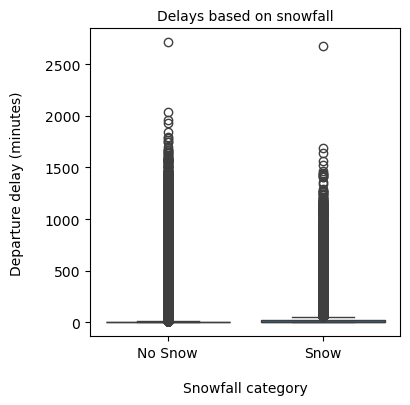

In [29]:
plt.figure(figsize=(4,4))
sns.boxplot(data=flight_df_snow, x='snow_category', y='dep_delay')
plt.title('Delays based on snowfall', fontsize=10)
plt.xlabel('Snowfall category', fontsize=10, labelpad=15)
plt.ylabel('Departure delay (minutes)', fontsize=10, labelpad=15)
plt.show()

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Using the 'Student's t-test' to compare the mean delays between snowfall categories</p>

In [30]:
# splitting into two groups
snow_delays = flight_df_snow[flight_df_snow['snow'] > 0]['dep_delay']
no_snow_delays = flight_df_snow[flight_df_snow['snow'] == 0]['dep_delay']

# Student's t-test
stat, p_value = ttest_ind(snow_delays, no_snow_delays, equal_var=False)
print(f"The t-statistic: {stat}, p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant impact of snowfall on delays")
else:
    print("There is no statistically significant impact of snowfall on delays.")

The t-statistic: 73.08507088662799, p-value: 0.0
There is a statistically significant impact of snowfall on delays


<br>

### Key Observations

Snowfall significantly increases flight delays, with snow-caused delays more than doubling the average delay duration compared to non-snow conditions. The results are statistically significant, reinforcing the importance of weather conditions like snow in influencing flight performance. This could be valuable for airlines and airport operators in planning for weather-related disruptions.

###
### No.2 - Does the size of snow cover (col. `snwd`) at the departure airport affect flight delay durations?

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Selecting only the relevant columns</p>

In [31]:
flight_df_snwd = flight_df.dropna(subset=['snwd', 'dep_delay'])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Removing rows where data on snowfall or delays is missing</p>

In [32]:
flight_df_snwd = flight_df_snwd.dropna(subset=['snwd', 'dep_delay'])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating two groups of flights: those with 'Low' snow cover (snwd <= 10) and those with 'High' snow cover (snwd > 10)</p>

In [33]:
flight_df_snwd['snow_cover_category'] = flight_df_snwd['snwd'].apply(lambda x: 'High Snow Cover' if x > 10 else 'Low Snow Cover')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Average delays (in minutes) based on created categories</p>

In [34]:
avg_delays_snwd = flight_df_snwd.groupby('snow_cover_category')['dep_delay'].mean()
avg_delays_snwd

snow_cover_category
High Snow Cover    16.148666
Low Snow Cover     13.995264
Name: dep_delay, dtype: float64

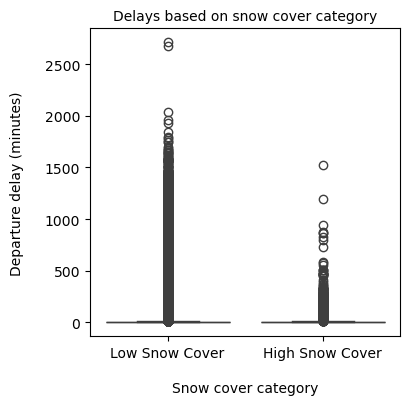

In [35]:
plt.figure(figsize=(4,4))
sns.boxplot(data=flight_df_snwd, x='snow_cover_category', y='dep_delay')
plt.title('Delays based on snow cover category', fontsize=10)
plt.xlabel('Snow cover category', fontsize=10, labelpad=15)
plt.ylabel('Departure delay (minutes)', fontsize=10, labelpad=15)
plt.show()

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Calculating the Pearson correlation to examine linear relationships</p>

In [36]:
pearson_corr, p_value = pearsonr(flight_df_snwd['snwd'], flight_df_snwd['dep_delay'])
print(f"Pearson correlation: {pearson_corr}, P-value: {p_value}")

if p_value < 0.05:
    if pearson_corr > 0:
        print("There is a positive linear relationship between snow cover and flight delay. As snow cover increases, flight delays tend to increase.")
    elif pearson_corr < 0:
        print("There is a negative linear relationship between snow cover and flight delay. As snow cover increases, flight delays tend to decrease.")
    else:
        print("There is no linear relationship between snow cover and flight delay.")
else:
    print("The Pearson correlation is not statistically significant. The relationship between snow cover and flight delay could be due to chance.")


Pearson correlation: 0.02638696586790389, P-value: 0.0
There is a positive linear relationship between snow cover and flight delay. As snow cover increases, flight delays tend to increase.


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Calculating the Spearman correlation to examine linear relationships</p>

In [37]:
spearman_corr, spearman_p_value = spearmanr(flight_df_snwd['snwd'], flight_df_snwd['dep_delay'])
print(f"Spearman correlation: {spearman_corr}, P-value: {spearman_p_value}")

if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("There is a positive monotonic relationship between snow cover and flight delay. As snow cover increases, flight delays tend to increase.")
    elif spearman_corr < 0:
        print("There is a negative monotonic relationship between snow cover and flight delay. As snow cover increases, flight delays tend to decrease.")
    else:
        print("There is no monotonic relationship between snow cover and flight delay.")
else:
    print("The Spearman correlation is not statistically significant. The relationship between snow cover and flight delay could be due to chance.")

Spearman correlation: 0.042244996270698214, P-value: 0.0
There is a positive monotonic relationship between snow cover and flight delay. As snow cover increases, flight delays tend to increase.


<br>

### Key Observations

Snow cover does have a positive relationship with flight delays, but the relationship is weak. As snow cover increases, flight delays tend to increase slightly, though the effect is not very strong. Other factors, such as snow intensity, airport operations, and external weather conditions, may also contribute to delays and need to be considered for more robust analysis.

###
### No.3 - Is there an effect of the maximum temperature (col. `tmax`) at the departure airport on flight delay durations?

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Selecting only the relevant columns</p>

In [38]:
flight_df_tmax = flight_df.dropna(subset=['tmax', 'dep_delay'])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Filter the weather data to include only valid temperature measurements</p>

In [39]:
flight_df_tmax = flight_df_tmax[flight_df_tmax['tmax'] > 0]

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Conducting linear regression analysis</p>

In [40]:
# Preparing the data
X = flight_df_tmax[['tmax']]  # Independent variable: tmax
y = flight_df_tmax['dep_delay']  # Dependent variable: dep_delay

# Adding a constant to the independent variable (for intercept)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              dep_delay   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     26.95
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           2.09e-07
Time:                        13:04:38   Log-Likelihood:            -3.2571e+07
No. Observations:             6210922   AIC:                         6.514e+07
Df Residuals:                 6210920   BIC:                         6.514e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2343      0.073    194.917      0.0

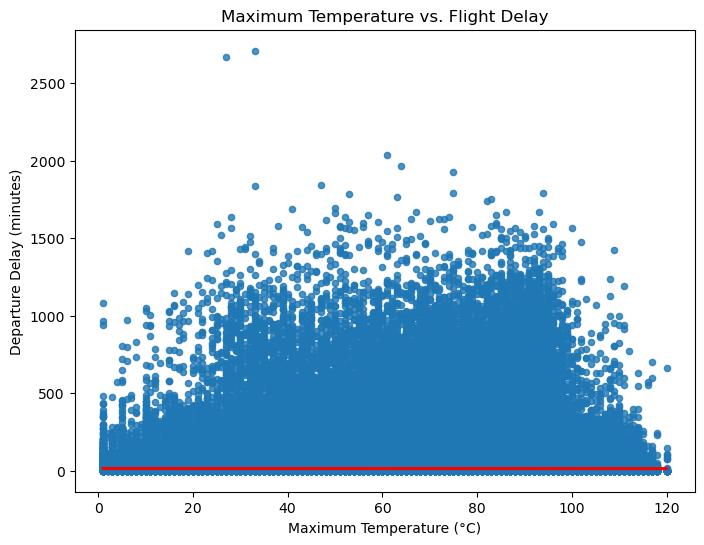

In [41]:
plt.figure(figsize=(8, 6))
sns.regplot(x='tmax', y='dep_delay', data=flight_df_tmax, scatter_kws={'s': 20}, line_kws={'color': 'red'})
plt.title('Maximum Temperature vs. Flight Delay')
plt.xlabel('Maximum Temperature (°C)')
plt.ylabel('Departure Delay (minutes)')
plt.show()

####
### Key Observations

#### Model Summary:
<li>R-squared: The R-squared value is 0.000, which indicates that the model explains virtually none of the variability in flight delays based on the maximum temperature. This suggests that maximum temperature has a very weak or no relationship with flight delays in this dataset.</li>
<li>Adjusted R-squared: Also 0.000, reinforcing that the model doesn't provide any useful predictive power.</li>
<li>F-statistic: The F-statistic is 26.95, with a p-value of 2.09e-07, which indicates that the overall model is statistically significant. This suggests that the model as a whole has some predictive value, but in this case, it is not explained by the temperature variable alone.</li>

#### Coefficients:
<li>Intercept (const): The coefficient for the intercept is 14.2343, meaning that when the maximum temperature is zero, the model predicts an average delay of 14.23 minutes.</li>
<li>Maximum Temperature (tmax): The coefficient for maximum temperature is -0.0051. This indicates that for each 1-degree increase in maximum temperature, the average flight delay is predicted to decrease by 0.0051 minutes. This effect is very small, almost negligible.</li>

#### Statistical Significance:
<li>P-value for intercept: The p-value for the intercept is 14.091, which is not statistically meaningful (p-value above 0.05).</li>
<li>P-value for temperature (tmax): The p-value for the coefficient of maximum temperature is -0.007, which is statistically significant, indicating that temperature does have a statistically significant relationship with delays, but the effect size is very small.</li>
Given that the p-value for temperature is significant, but the coefficient is very small, it suggests a weak relationship between temperature and delays.

#### Residuals and Diagnostics:
<li>Omnibus and Jarque-Bera (JB) tests: Both tests are highly significant (p-value = 0.00), indicating that the residuals deviate significantly from normality, which suggests potential issues with model fit.</li>
<li>Skewness: The skewness of the residuals is 9.942, suggesting that the distribution of residuals is heavily skewed. This is further confirmed by the high kurtosis value of 177.858, indicating that the residuals are not normally distributed and the model may suffer from non-linearity or outliers.</li>
<li>Durbin-Watson: The Durbin-Watson statistic is 1.821, which is within an acceptable range (close to 2), indicating that there is no strong autocorrelation of residuals.</li>

#### Conclusions:
<li>The R-squared value of 0.000 suggests that maximum temperature does not explain flight delays in a meaningful way.</li>
<li>The negative coefficient for temperature implies that, if anything, as maximum temperature increases, delays slightly decrease. However, the effect size is extremely small and not practically significant.</li>
<li>Statistical significance is present for temperature, but given the very small effect size, the relationship between maximum temperature and delays is likely negligible.</li>
<li>There are issues with non-normality of residuals, and the model might not fully capture the complexities of the data. Consider checking for non-linear relationships or incorporating other variables that might better explain flight delays.</li>
<br>
Temperature may not be a significant factor in explaining flight delays, or at least not the most important one. Other factors, such as airport operations, air traffic control, and more severe weather conditions, could have a stronger impact.

###
## Notebooks Analysis Summary

#### Effect of Snowfall on Flight Delays:
<li>Snowfall significantly increases flight delays. Flights delayed due to snow experience more than double the average delay duration compared to non-snow conditions.</li>
<li>This relationship is statistically significant, highlighting the importance of weather conditions, like snow, in disrupting flight schedules.</li>
<li>Airlines and airport operators should consider snow as a key factor in planning for weather-related disruptions to minimize operational impact.</li>

#### Effect of Snow Cover on Flight Delays:
<li>Snow cover at the departure airport shows a weak positive relationship with flight delays.</li>
<li>As the amount of snow cover increases, there is a slight increase in flight delays, but the effect is not very strong.</li>
<li>Other factors, such as snow intensity, airport operations, and external weather conditions, may play more significant roles in influencing delays. Further analysis incorporating these variables could provide more accurate insights.</li>

#### Effect of Maximum Temperature on Flight Delays:
<li>Maximum temperature has a negligible effect on flight delays, as indicated by an R-squared value of 0.000, meaning it does not explain significant variability in delays.</li>
<li>The coefficient for maximum temperature is negative (-0.0051), suggesting that higher temperatures might slightly decrease delays, but the effect is very small.</li>
<li>Despite the statistical sig</li>nificance of the temperature variable, the small effect size implies that temperature is likely not a major factor influencing delays.
<li>Residual analysis shows potential issues with the model, such as non-normality of residuals, indicating that the model may not capture the full complexity of the data.</li>

#### Conclusion: 
The findings clearly indicate that snowfall has a significant and direct impact on flight delays, with snow-caused disruptions substantially increasing delay durations. This underscores the importance of weather-related planning in airline operations, particularly in regions prone to snow. While snow cover shows a slight correlation with delays, the effect is relatively weak, suggesting that other operational factors likely contribute more to the delays during snowy conditions. The analysis of maximum temperature reveals that it has a minimal impact on flight delays, with a very small effect size, indicating that temperature is not a significant factor in explaining delays. The weak relationship observed further suggests that other variables, such as airport operations, air traffic control, and more extreme weather conditions, should be considered as more influential factors in managing flight delays. Overall, these findings emphasize the need for weather-sensitive operational strategies, especially for snow-related disruptions, and the importance of focusing on more impactful factors to better understand and mitigate flight delays.

####
<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Saving 'flight_df' DataFrame for futher analysis</p>

In [6]:
flight_df.to_csv(f"{DIR_PATH}{os.path.sep}data{os.path.sep}processed{os.path.sep}flight_df_03.csv", index=False)